X_train_final shape: (434372, 10, 10)
X_val shape: (108593, 10, 10)
y_train_final shape: (434372,)
y_val shape: (108593,)
Epoch 1/10


2024-05-16 15:39:59.809914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 15:39:59.978590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   7/6788 [..............................] - ETA: 1:02 - loss: 0.7105 - accuracy: 0.6116   

2024-05-16 15:40:00.140635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6788/6788 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.9921

2024-05-16 15:40:59.088090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 15:40:59.143409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6788/6788 [==============================] - 66s 10ms/step - loss: 0.1383 - accuracy: 0.9921 - val_loss: 0.0440 - val_accuracy: 0.9902
Epoch 2/10
6788/6788 [==============================] - 59s 9ms/step - loss: 0.0788 - accuracy: 0.9844 - val_loss: 0.0352 - val_accuracy: 0.9815
Epoch 3/10
6788/6788 [==============================] - 59s 9ms/step - loss: 0.0632 - accuracy: 0.9839 - val_loss: 0.0332 - val_accuracy: 0.9845
Epoch 4/10
6788/6788 [==============================] - 59s 9ms/step - loss: 0.0554 - accuracy: 0.9850 - val_loss: 0.0416 - val_accuracy: 0.9744
Epoch 5/10
6788/6788 [==============================] - 59s 9ms/step - loss: 0.0518 - accuracy: 0.9856 - val_loss: 0.0265 - val_accuracy: 0.9864
Epoch 6/10
6788/6788 [==============================] - 60s 9ms/step - loss: 0.0489 - accuracy: 0.9861 - val_loss: 0.0247 - val_accuracy: 0.9874
Epoch 7/10
6788/6788 [==============================] - 61s 9ms/step - loss: 0.0469 - accuracy: 0.9868 - val_loss: 0.0267 - val_accuracy: 0.

2024-05-16 15:49:05.141840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 15:49:05.182198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4242/4242 [==============================] - 11s 2ms/step


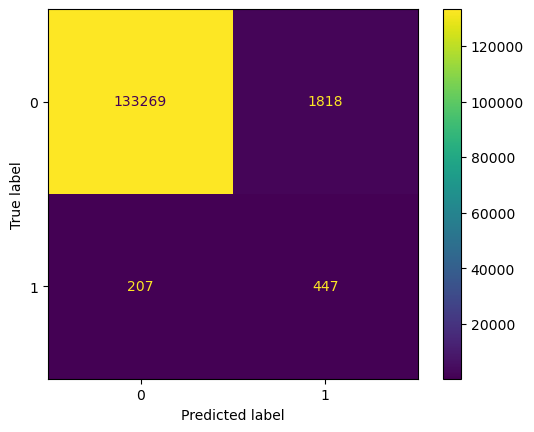

Final Test Accuracy: 0.9851
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    135087
           1       0.20      0.68      0.31       654

    accuracy                           0.99    135741
   macro avg       0.60      0.84      0.65    135741
weighted avg       0.99      0.99      0.99    135741



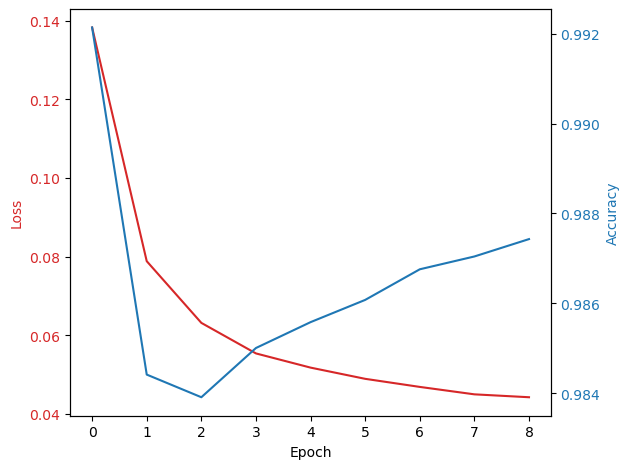

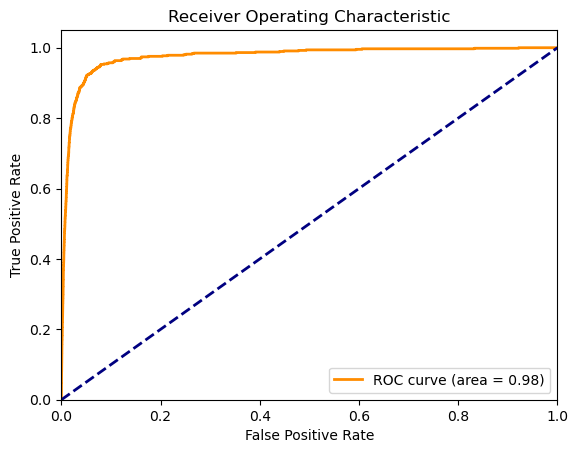

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load data
files = [
    'Data/29_tracks_labeled.csv', 'Data/28_tracks_labeled.csv', 'Data/27_tracks_labeled.csv', 
    'Data/26_tracks_labeled.csv', 'Data/25_tracks_labeled.csv', 'Data/22_tracks_labeled.csv', 
    'Data/21_tracks_labeled.csv', 'Data/20_tracks_labeled.csv'
]
data = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

# Sort data by time if there's a timestamp column
data = data.sort_values(by=['frame'])

# Split data chronologically
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Assuming the datasets have been properly labeled and contain the 'stopped_before_pedestrian' column
features_cols = ['xCenter', 'yCenter', 'xVelocity', 'yVelocity', 'xAcceleration', 'yAcceleration', 'lonVelocity', 'latVelocity', 'lonAcceleration', 'latAcceleration']

# Split features and labels for training data
X_train = train_data[features_cols]
y_train = train_data['stopped_before_pedestrian']

# Split features and labels for testing data
X_test = test_data[features_cols]
y_test = test_data['stopped_before_pedestrian']

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Use a simple class weight value
class_weight = {0: 1, 1: 10}

# Adjust the time steps to a larger value
time_steps = 10  # Adjust as needed based on the data

# Ensure the number of samples is a multiple of the time steps
num_samples = (X_train.shape[0] // time_steps) * time_steps
X_train = X_train[:num_samples]
y_train = y_train[:num_samples]

num_samples_test = (X_test.shape[0] // time_steps) * time_steps
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]

# Reshape y_train and y_test to match the number of sequences
y_train = np.array(y_train).reshape((-1, time_steps))[:, 0]
y_test = np.array(y_test).reshape((-1, time_steps))[:, 0]

# Reshape data for LSTM: [samples, time_steps, features]
X_train = X_train.reshape((-1, time_steps, X_train.shape[1]))
X_test = X_test.reshape((-1, time_steps, X_test.shape[1]))

# Train/validation split from training data
train_val_split = int(0.8 * len(X_train))
X_train_final = X_train[:train_val_split]
X_val = X_train[train_val_split:]
y_train_final = y_train[:train_val_split]
y_val = y_train[train_val_split:]

# Verify shapes before building the model
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train_final shape: {y_train_final.shape}")
print(f"y_val shape: {y_val.shape}")

# Build the simplified model
model = Sequential([
    LSTM(50, input_shape=(time_steps, X_train.shape[2]), return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with adjusted batch size
history = model.fit(X_train_final, y_train_final, epochs=10, batch_size=64, validation_data=(X_val, y_val), class_weight=class_weight, callbacks=[early_stopping])

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Print final accuracy and classification report
final_accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print(classification_report(y_test, y_pred_classes))

# Plot training loss and accuracy
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(history.epoch, history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(history.epoch, history.history['accuracy'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()